In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
from jax.random import split, PRNGKey
def init_RWKV_params(input_size, emb_size, h_size,  num_layer, out_size, Ny, Nx, key):
    key, emb_key, init_x_key, init_y_key, last_x1_key, last_x2_key, last_y1s_key, last_y1e_key, last_y2_key, key_tout, key_txout, key_talpha_out, key_tbeta_out, key_tlast_x, key_clast_x, key_cxout = split(key, 16)
    wemb = random.uniform(emb_key, (input_size, emb_size), minval=-1e-4, maxval=1e-4) #input hasn't been connected
    x_init = random.uniform(init_x_key, (Nx, emb_size), minval=-1e-4, maxval=1e-4)
    y_init = random.uniform(init_y_key, (Ny, emb_size), minval=-1e-4, maxval=1e-4)
    last_x1_init = random.uniform(last_x1_key, (Nx, num_layer, emb_size), minval=-1e-4, maxval=1e-4)
    last_x2_init = random.uniform(last_x2_key, (Nx, num_layer, emb_size), minval=-1e-4, maxval=1e-4)
    last_y1s_init = random.uniform(last_y1s_key, (Ny+1, num_layer, emb_size), minval=-1e-4, maxval=1e-4)
    last_y1e_init = random.uniform(last_y1e_key, (Ny+1, num_layer, emb_size), minval=-1e-4, maxval=1e-4)
    last_y2_init = random.uniform(last_y2_key, (Ny, num_layer, emb_size), minval=-1e-4, maxval=1e-4)
    t_alpha_init_x, t_alpha_init_y, t_beta_init_x, t_beta_init_y = jnp.zeros((Nx, num_layer, h_size)), jnp.zeros((Ny, num_layer, h_size)), jnp.zeros((Nx, num_layer, h_size)), jnp.zeros((Ny, num_layer, h_size))
    t_xout = random.normal(key_tout, (Ny, Nx, num_layer, emb_size, 2*emb_size))
    t_alphaout = random.normal(key_talpha_out, (Ny, Nx, num_layer, h_size, 2*h_size))
    t_betaout = random.normal(key_tbeta_out, (Ny, Nx, num_layer, h_size, 2*h_size))
    c_xout = random.normal(key_cxout, (Ny, Nx, num_layer, emb_size, 2*emb_size))    
    emb_size, h_size = 2*emb_size, 2*h_size #tensor product the input from two directions and concantenate the hidden state
    wln_in, bln_in, wln_out, bln_out = jnp.ones((Ny, Nx, emb_size)), jnp.zeros((Ny, Nx, emb_size)), jnp.ones((Ny, Nx, emb_size)), jnp.zeros((Ny, Nx, emb_size))  #in&out layer_norm params
    wln, bln = jnp.ones((2, Ny, Nx, num_layer, emb_size)), jnp.zeros((2, Ny, Nx, num_layer, emb_size))  #time&channel layer_norm params

    # time mixing params
    decay = jnp.tile(-5 + jnp.array([8*(jnp.arange(h_size)/(h_size-1))**(0.7 + 1.3*i/(num_layer-1)) for i in range(num_layer)]), (Ny, Nx, 1, 1))
    bonus = jnp.tile(0.5*(jnp.arange(h_size)%3-1)+jnp.log(0.3), (Ny, Nx, num_layer, 1))
    t_mix_k = jnp.tile(jnp.array([(jnp.arange(emb_size) / emb_size) ** (1 - i / num_layer) for i in range(num_layer)]), (Ny, Nx, 1, 1))
    t_mix_v = t_mix_k + jnp.transpose(jnp.tile(jnp.arange(num_layer) * 0.3 / (num_layer - 1), (Ny, Nx, emb_size, 1)), (0, 1, 3, 2))
    t_mix_r = 0.5 * t_mix_k
    t_wk, t_wv, t_wr = jnp.zeros((Ny, Nx, num_layer, h_size, emb_size)), jnp.zeros((Ny, Nx, num_layer, h_size, emb_size)), jnp.zeros((Ny, Nx, num_layer, h_size, emb_size))
    t_wout = jnp.sqrt(h_size/emb_size)*random.normal(key_tout, (Ny, Nx, num_layer, emb_size, h_size))
    t_wlast_x = random.normal(key_tlast_x, (Ny, Nx, num_layer, emb_size, 2*emb_size)) #since last_x is twice larger than x

    # channel mixing params
    c_mix_k, c_mix_r = t_mix_k, t_mix_k
    c_wr, c_wv, c_wk = jnp.zeros((Ny, Nx, num_layer, emb_size, emb_size)), jnp.zeros((Ny, Nx, num_layer, emb_size, emb_size)), jnp.zeros((Ny, Nx, num_layer, emb_size, emb_size))
    c_wlast_x = random.normal(key_clast_x, (Ny, Nx, num_layer, emb_size, 2*emb_size)) #since last_x is twice larger than x
    # output params
    whead, bhead = jnp.tile(jnp.eye(emb_size), (Ny, Nx, 1, 1)), jnp.zeros((Ny, Nx, emb_size))
    wprob, bprob, wphase, bphase = jnp.zeros((out_size, emb_size)), jnp.zeros((out_size)), jnp.zeros((out_size, emb_size)), jnp.zeros((out_size))
    RWKV_cell_params = wln[0], bln[0], wln[1], bln[1], decay, bonus, t_mix_r, t_mix_v, t_mix_k, t_wr, t_wv, t_wk, t_wout, t_wlast_x, c_mix_k, c_mix_r, c_wr, c_wv, c_wk, c_wlast_x, t_xout, t_alphaout, t_betaout, c_xout

    return (wemb, x_init, y_init, last_x1_init, last_x2_init, last_y1s_init, last_y1e_init, last_y2_init, t_alpha_init_x, t_alpha_init_y, t_beta_init_x, t_beta_init_y,  wln_in, bln_in, wln_out, bln_out, whead, bhead, wprob, bprob, wphase, bphase, RWKV_cell_params)

In [2]:
def int_to_binary_array(x, num_bits):
    """
    Converts an array of integers to their binary representation arrays with a fixed number of bits.
    This function is designed to be compatible with Jax's vmap for vectorization over an array of integers.

    Parameters:
    - x: An array of integers, the numbers to convert.
    - num_bits: Integer, the fixed number of bits for the binary representation.

    Returns:
    - A 2D Jax array where each row is the binary representation of an integer in 'x'.
    """
    # Create an array of bit positions: [2^(num_bits-1), 2^(num_bits-2), ..., 1]
    powers_of_two = 2 ** jnp.arange(num_bits - 1, -1, -1)

    # Expand dims of x and powers_of_two for broadcasting
    x_expanded = x[:, None]
    powers_of_two_expanded = powers_of_two[None, :]

    # Perform bitwise AND between each number and each power of two, then right shift to get the bit value
    binary_matrix = (x_expanded & powers_of_two_expanded) >> jnp.arange(num_bits - 1, -1, -1)

    return binary_matrix.astype(jnp.int32)  # Ensure the result is integer


def binary_array_to_int(binary_array, num_bits):
    """
    Converts a 2D array of binary representations to their decimal equivalents.

    Parameters:
    - binary_array: A 2D Jax array where each row represents a binary number.

    Returns:
    - A 1D Jax array of integers, the decimal equivalents of the binary representations.
    """
    powers_of_two = 2 ** jnp.arange(num_bits - 1, -1, -1)
    # Multiply each bit by its corresponding power of two and sum the results
    decimals = jnp.dot(binary_array, powers_of_two)
    return decimals

In [13]:
from functools import partial
from jax.lax import scan
from jax.random import categorical

@partial(jax.jit, static_argnames=['fixed_params'])
def sample_prob(params, fixed_params, ny_nx_indices, key):

    Ny, Nx, py, px, mag_fixed, magnetization, num_layer = fixed_params
    int_to_binary = partial(int_to_binary_array, num_bits=px * py)
    
    def scan_fun_1d(carry_1d, indices):
        ny, nx = indices
        
        input_x, input_yi, last_x1, last_x1s, last_x1e, last_x2, last_y1i, last_y2i, t_alpha_state_x1, t_beta_state_x1, t_alpha_state_yi, t_beta_state_yi, key = carry_1d
    
        rnn_input = jnp.concatenate((input_yi, input_x[nx]), axis=0)
        last_state = jnp.concatenate((last_y2i, last_x1s[nx], last_x2[nx], last_x1e[nx]), axis=1)
        t_alpha_state = jnp.concatenate((t_alpha_state_yi, t_alpha_state_x1[nx]), axis=1)
        t_beta_state = jnp.concatenate((t_beta_state_yi, t_beta_state_x1[nx]), axis=1)
        x, t_states, c_states, prob, phase = RWKV_step(rnn_input, (last_state, t_alpha_state, t_beta_state), (last_state), num_layer, RWKV_net_params, jnp.array([ny, nx]))

        key, subkey = split(key)
        block_sample = categorical(subkey, jnp.log(prob))
        probs, phase = prob[block_sample], phase[block_sample]
        last_y2i = last_y1i
        last_y1i, t_alpha_state_yi, t_beta_state_yi= t_states
        input_yi = wemb[block_sample]
        return (input_x, input_yi, last_x1, last_x1s, last_x1e, last_x2, last_y1i, last_y2i, t_alpha_state_x1, t_beta_state_x1, t_alpha_state_yi, t_beta_state_yi, key), (last_y1i, t_alpha_state_yi, t_beta_state_yi, block_sample, probs, phase)

    def scan_fun_2d(carry_2d, indices):  # indices:[[0,0], [0,1], [0,2]...[0,Nx-1]]

        input_x, input_y, last_x1, last_x2, last_y1s, last_y1e, last_y2, t_alpha_state_x, t_beta_state_x, t_alpha_state_y, t_beta_state_y ,key = carry_2d
        ## The shape of last_y1s, last_y1e are (Ny+1) 
        index = indices[0, 0]
        print(last_y1s[index][None, ...].shape)
        print(last_x1[:-1].shape)
        last_x1s = jnp.concatenate((last_y1s[index][None, ...], last_x1[:-1]), axis=0)
        last_x1e = jnp.concatenate((last_x1[1:], last_y1e[index][None, ...]), axis=0)
        carry_1d = input_x, input_y[index], last_x1, last_x1s, last_x1e, last_x2, last_y1e[index+1], last_y2[index], t_alpha_state_x, t_beta_state_x, t_alpha_state_y[index], t_beta_state_y[index], key
        _, y = scan(scan_fun_1d, carry_1d, indices)
        '''
        The stacked y1i becomes the x1 in the next row
        The stacked y2i becomes the x2e in the next row
        '''
        last_x2 = last_x1 # x2 for the next row
        last_x1, t_alpha_state_x1, t_beta_state_x1, row_block_sample, row_prob, row_phase = y
        key = _[-1]
        last_x2 = jnp.flip(last_x2, 0)
        last_x1 = jnp.flip(last_x1, 0)
        t_alpha_state_x1 = jnp.flip(t_alpha_state_x1, 0)
        t_beta_state_x1 = jnp.flip(t_beta_state_x1, 0)
        input_x = wemb[jnp.flip(row_block_sample)]
        row_block_sample = lax.cond(index % 2, lambda x: jnp.flip(x, 0), lambda x: x, row_block_sample)
        row_prob = lax.cond(index % 2, lambda x: jnp.flip(x, 0), lambda x: x, row_prob)
        row_phase = lax.cond(index % 2, lambda x: jnp.flip(x, 0), lambda x: x, row_phase)

        return (input_x, input_y, last_x1, last_x2, last_y1s, last_y1e, last_y2, t_alpha_state_x1, t_beta_state_x1, t_alpha_state_y, t_beta_state_y, key), (row_block_sample, row_prob, row_phase)

    # initialization
    wemb = params[0]
    init = (*params[1:12], key)
    RWKV_net_params = params[12:]
    __, (samples, probs, phase) = scan(scan_fun_2d, init, ny_nx_indices)
    samples = vmap(int_to_binary, 0)(samples).reshape(Ny*py, Nx*px)
    log_probs, phase = jnp.sum(jnp.log(probs)), jnp.sum(phase)
    samples_log_amp = log_probs / 2 + phase * 1j

    return samples, samples_log_amp



In [21]:
key = PRNGKey(0)
params = init_RWKV_params(input_size=2, emb_size=8, h_size=5, num_layer=3, out_size=2, Ny=3, Nx=3, key=key)
fixed_params = (3, 3, 1, 1, 0, 0, 3)
ny_nx_indices = jnp.array([[[i, j] for j in range(3)] for i in range(3)])
key = PRNGKey(0)
sample_prob(params, fixed_params, ny_nx_indices, key)

(Array([[0, 0, 1],
        [0, 0, 1],
        [0, 1, 0]], dtype=int32),
 Array(-3.1191623+0.j, dtype=complex64))

In [20]:
from jax import nn
from jax import lax

def time_mixing(x, t_state, decay, bonus, t_mix_k, t_mix_v, t_mix_r, t_wlast_x, Wk, Wv, Wr, Wout, t_xout, t_alphaout, t_betaout):
    last_x, last_alpha, last_beta = t_state
    last_x = t_wlast_x @ last_x
    print("t:", t_mix_k.shape)
    k = Wk @ (x * t_mix_k + last_x * (1 - t_mix_k))
    v = Wv @ (x * t_mix_v + last_x * (1 - t_mix_v))
    r = Wr @ (x * t_mix_r + last_x * (1 - t_mix_r))
    wkv = (last_alpha + jnp.exp(bonus + k) * v) / \
          (last_beta + jnp.exp(bonus + k))
    rwkv = nn.sigmoid(r) * wkv

    alpha = jnp.exp(-jnp.exp(decay)) * last_alpha + jnp.exp(k) * v
    beta = jnp.exp(-jnp.exp(decay)) * last_beta + jnp.exp(k)
    alpha = t_alphaout @ alpha
    beta = t_betaout @ beta
    x = t_xout @ x
    return Wout @ rwkv, (x, alpha, beta)

def channel_mixing(x, c_states, c_mix_k, c_mix_r, c_wlast_x, Wk, Wr, Wv, c_xout):
    last_x = c_states #change tuple into array
    last_x = c_wlast_x @ last_x

    k = Wk @ (x * c_mix_k + last_x * (1 - c_mix_k))
    r = Wr @ (x * c_mix_r + last_x * (1 - c_mix_r))    
    vk = Wv @ nn.relu(k) ** 2
    x = c_xout @ x
    return nn.sigmoid(r) * vk, x

def layer_norm(x, w, b):
    mean = jnp.mean(x)
    std =  jnp.sqrt((jnp.sum((x - mean)**2) + 1e-10)/(x.size-1))
    return (x - mean)/ std * w + b

def RWKV_step(x, t_states, c_states, num_layer, RWKV_net_params, indices):
    ny, nx = indices
    w_in, b_in, whead, bhead, w_out, b_out, wprob, bprob, wphase, bphase, RWKV_cell_params = RWKV_net_params
    x = layer_norm(x, w_in[ny, nx], b_in[ny, nx])
    _ , y = lax.scan(partial(RWKV_cell, params = tuple(px[nx] for px in tuple(py[ny] for py in RWKV_cell_params)), cell_t_states = t_states, cell_c_states = c_states), x, jnp.arange(num_layer))
    x = _[0]
    t_states, c_states = y
    x = whead[ny, nx] @ layer_norm(x, w_out[ny, nx], b_out[ny, nx]) + bhead[ny, nx]
    prob = nn.softmax(wprob @ x + bprob)
    phase = 2*jnp.pi*nn.soft_sign(wphase @ x + bphase)
    return x, t_states, c_states, prob, phase

def RWKV_cell(carry, i, params, cell_t_states, cell_c_states): # carry = (x, t_states, c_states)
    #modify it for different layer of t_state and c_state and x . 
    x = carry
    wln_i, bln_i, wln_m, bln_m, decay, bonus, t_mix_r, t_mix_v, t_mix_k, t_wr, t_wv, t_wk, t_wout,t_wlast_x, c_mix_k, c_mix_r, c_wr, c_wv, c_wk, c_wlast_x, t_xout, t_alphaout, t_betaout, c_xout = tuple(p[i] for p in params) 
    layer_t_states = tuple(t[i] for t in cell_t_states)
    layer_c_states = cell_c_states[i]

    x_ = layer_norm(x, wln_i, bln_i)
    dx, output_t_states = time_mixing(x_, layer_t_states, decay, bonus, t_mix_r, t_mix_v, t_mix_k, t_wlast_x, t_wr, t_wv, t_wk, t_wout,  t_xout, t_alphaout, t_betaout)
    x = x + dx
    x_ = layer_norm(x, wln_m, bln_m)
    dx, output_c_states = channel_mixing(x_, layer_c_states, c_mix_k, c_mix_r, c_wlast_x, c_wr, c_wv, c_wk, c_xout)
    x = x + dx
    # carry need to be modified
    return x, (output_t_states, output_c_states)

In [289]:
key = PRNGKey(0)
params = init_RWKV_params(input_size=2, emb_size=5, h_size=7, num_layer=4, out_size=2, Ny=3, Nx=3, key=key)
wemb, x_init, y_init, last_x1_init, last_x2_init, last_y1s_init, last_y1e_init, last_y2_init, t_alpha_init_x, t_alpha_init_y, t_beta_init_x, t_beta_init_y,  wln_in, bln_in, wln_out, bln_out, whead, bhead, wprob, bprob, wphase, bphase, RWKV_cell_params = params
x = jnp.concatenate((wemb[0], wemb[1]), axis = 0)
last_x = jnp.concatenate((last_y2_init[0], last_y1s_init[0], last_x2_init[0], last_x1_init[1]), axis = 1)
t_alpha_init = jnp.concatenate((t_alpha_init_x[0], t_alpha_init_y[0]), axis = 1)
t_beta_init = jnp.concatenate((t_beta_init_x[0], t_beta_init_y[0]), axis = 1)


In [265]:
wln_i, bln_i, wln_m, bln_m, decay, bonus, t_mix_r, t_mix_v, t_mix_k, t_wr, t_wv, t_wk, t_wout,t_wlast_x, c_mix_k, c_mix_r, c_wr, c_wv, c_wk, c_wlast_x = RWKV_cell_params
for params in RWKV_cell_params:
    print(params.shape)

(3, 3, 4, 10)
(3, 3, 4, 10)
(3, 3, 4, 10)
(3, 3, 4, 10)
(3, 3, 4, 14)
(3, 3, 4, 14)
(3, 3, 4, 10)
(3, 3, 4, 10)
(3, 3, 4, 10)
(3, 3, 4, 14, 10)
(3, 3, 4, 14, 10)
(3, 3, 4, 14, 10)
(3, 3, 4, 10, 14)
(3, 3, 4, 10, 20)
(3, 3, 4, 10)
(3, 3, 4, 10)
(3, 3, 4, 10, 10)
(3, 3, 4, 10, 10)
(3, 3, 4, 10, 10)
(3, 3, 4, 10, 20)


In [266]:
fixed_params = (3, 3, 1, 1, 0, 0, 4)
ny_nx_indices = jnp.array([[[i, j] for j in range(3)] for i in range(3)])
key = PRNGKey(0)
sample_prob(params, fixed_params, ny_nx_indices, key)

(3, 4, 10, 20)
(3, 4, 10, 20)
(2,)
(3, 4, 10, 20)
(3, 4, 10, 20)
(2,)


ValueError: not enough values to unpack (expected 12, got 3)

In [4]:
import jax
import jax.numpy as jnp
h_size = 6
num_layer = 2 
(-5 + jnp.array([8*(jnp.arange(h_size)/(h_size-1))**(0.7 + 1.3*i/(num_layer-1)) for i in range(num_layer)]))

Array([[-5.        , -2.4069493 , -0.7875767 ,  0.5949459 ,  1.8431015 ,
         3.        ],
       [-5.        , -4.68      , -3.7199998 , -2.12      ,  0.12000036,
         3.        ]], dtype=float32)

In [3]:
0.5*(jnp.arange(h_size)%3-1)+jnp.log(0.3)

Array([-1.7039728, -1.2039728, -0.7039728, -1.7039728, -1.2039728,
       -0.7039728], dtype=float32, weak_type=True)

In [6]:
import jax
import jax.numpy as jnp
a = jnp.eye(3)[None,:,:]


In [7]:
def flip_sample(sample, x, y):
    return sample.at[x,y].set(1-sample[x, y])

In [30]:
from jax import vmap
vec_flip_sample = vmap(vmap(vmap(flip_sample, (None, None, 0)), (None, 0, None)),(0, None, None))

In [35]:
import time
import numpy as np
list = []
t = time.time()
a = np.tile(np.eye(16),(30, 1, 1))
for i in range (a.shape[0]):
    for y in range(a.shape[1]):
        for x in range(a.shape[2]):
            list.append(a)   
print(time.time()-t)

0.002005338668823242


In [36]:
t = time.time()
vec_flip_sample(a, jnp.arange(16), jnp.arange(16))
print(time.time()-t)

0.021869421005249023


In [53]:
import jax.lax as lax
def dis_matrix(M):
    out = []
    Ny, Nx = M.shape[0], M.shape[1]
    M_out = jnp.zeros((Ny, Nx, Ny, Nx))
    for i in range(Ny):
        for j in range(Nx):
            for k in range(Ny):
                for l in range(Nx):
                    print(((i==k) & (j==l)))
                    out.append(M_out.at[i, j, k, l].set(lax.cond(((i==k) & (j==l)), lambda a, b, c, d: 1, lambda a, b, c, d: ((a-c)**2+(b-d)**2)**3  , i, j, k, l)))
    return out

In [62]:
def staggered_magnetization(sample, L):
    # nj is a 2D array representing a lattice, where each row is a configuration
    # Calculate the staggered factor (-1)**(i+j) for a 2D grid
    staggered_factor = 1 - (jnp.indices(jnp.array([5, 5])).sum(axis=0)) % 2 * 2 

    return jnp.abs(jnp.sum((sample-0.5)*2 * staggered_factor)) / L**2

In [11]:
def staggered_magnetization(sample, L):
    # nj is a 2D array representing a lattice, where each row is a configuration
    # Calculate the staggered factor (-1)**(i+j) for a 2D grid
    staggered_factor = 1 - (jnp.indices((L, L)).sum(axis=0)) % 2 * 2

    return jnp.abs(jnp.sum((sample-0.5)*2 * staggered_factor)) / L**2
jax.jit(jax.vmap(staggered_magnetization, in_axes=(0, None)), static_argnames=['L'])(jnp.tile(jnp.eye(3), (2, 1, 1)), 3)

Array([0.5555556, 0.5555556], dtype=float32)

In [1]:
import jax
import jax.numpy as jnp

1 - (jnp.indices(jnp.array([5, 5])).sum(axis=0)) % 2 * 2 

Array([[ 1, -1,  1, -1,  1],
       [-1,  1, -1,  1, -1],
       [ 1, -1,  1, -1,  1],
       [-1,  1, -1,  1, -1],
       [ 1, -1,  1, -1,  1]], dtype=int32)

In [10]:
jnp.outer(jnp.array([1, 0]), jnp.array([0, 1])).ravel()

Array([0, 1, 0, 0], dtype=int32)

In [7]:
def binary_array_to_int(binary_array, num_bits):
    """
    Converts a 2D array of binary representations to their decimal equivalents.

    Parameters:
    - binary_array: A 2D Jax array where each row represents a binary number.

    Returns:
    - A 1D Jax array of integers, the decimal equivalents of the binary representations.
    """
    powers_of_two = 2 ** jnp.arange(num_bits - 1, -1, -1)
    # Multiply each bit by its corresponding power of two and sum the results
    decimals = jnp.dot(binary_array, powers_of_two)
    return decimals

In [8]:
binary_array_to_int(jnp.array([1, 0, 1]), 3)

Array(5, dtype=int32)

In [22]:
import numpy as np
a = np.random.uniform(size = (100))


array([0.41383359, 0.25422606, 0.36866871, 0.23232137, 0.37317606,
       0.02404975, 0.11333109, 0.08641187, 0.1343285 , 0.05385513,
       0.50081478, 0.60427048, 0.17863755, 0.70204059, 0.52180454,
       0.82245659, 0.91467819, 0.22666008, 0.32177232, 0.18351523,
       0.34527335, 0.6330418 , 0.32071911, 0.99225941, 0.65724411,
       0.45120482, 0.2929529 , 0.91634819, 0.27061327, 0.75671199,
       0.27644788, 0.38266732, 0.53487854, 0.97227441, 0.9013808 ,
       0.12855412, 0.46583419, 0.45645021, 0.87530666, 0.87462189,
       0.40826226, 0.07076857, 0.86488153, 0.63255568, 0.985933  ,
       0.38402985, 0.39434664, 0.77334714, 0.43306387, 0.5697004 ,
       0.10750879, 0.35482524, 0.6993147 , 0.02397043, 0.16236685,
       0.81282862, 0.67707991, 0.41084657, 0.34294921, 0.3254295 ,
       0.71415286, 0.42210605, 0.78727075, 0.68164797, 0.67360324,
       0.73552787, 0.47612139, 0.24487505, 0.95469881, 0.46495495,
       0.11442729, 0.40806291, 0.93719236, 0.16942264, 0.08042

In [32]:
b = np.random.normal(size = (100, 100))*0.1

In [33]:
import matplotlib.pyplot as plt
print(np.var(a))
np.var(b @ a)

0.07073306004601215


0.3188987005719188

In [91]:
import numpy as np
import jax.nn as nn
a = 10000
b = 1000
w1 = (2*np.random.uniform(size = (a, b))-1)/(np.sqrt(b/5))
w2 = (2*np.random.uniform(size = (a, b))-1)/(np.sqrt(b/5))
x = np.random.normal(size = (b,))
x = x/np.sqrt(np.mean(x**2))
y1 = nn.elu(w1 @ x)
y2 = nn.elu(w2 @ x)

In [92]:
print(np.var(x))
print(np.var(y1))
print(np.var(y2))

0.9999993519869641
0.9638375
0.955016


(array([  4.,  29.,  99., 191., 306., 207., 126.,  31.,   5.,   2.]),
 array([-3.28905525, -2.58103311, -1.87301097, -1.16498883, -0.45696669,
         0.25105545,  0.95907759,  1.66709973,  2.37512187,  3.08314401,
         3.79116615]),
 <BarContainer object of 10 artists>)

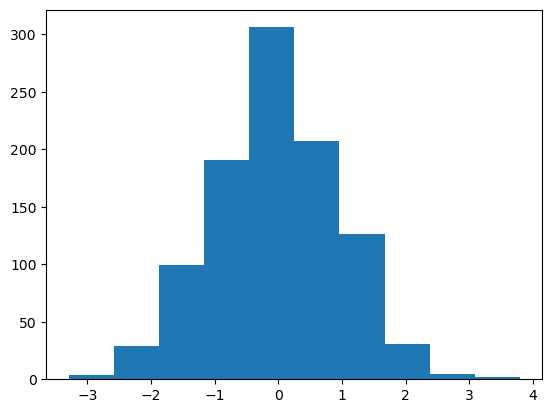

In [86]:
plt.hist(x)

(array([3443., 2144., 1665., 1270.,  789.,  430.,  192.,   44.,   16.,
           7.]),
 array([-0.99114805, -0.40525839,  0.18063131,  0.76652098,  1.35241067,
         1.93830037,  2.52418995,  3.11007977,  3.69596934,  4.28185892,
         4.86774874]),
 <BarContainer object of 10 artists>)

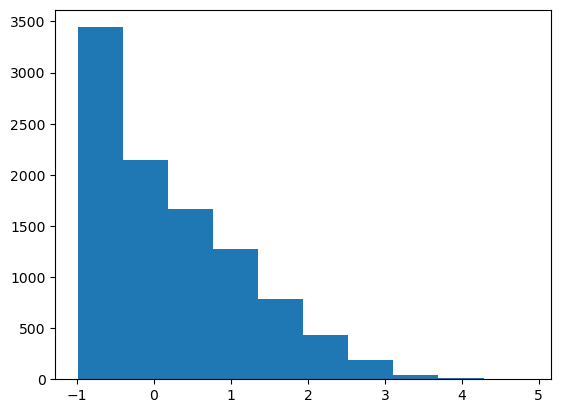

In [93]:
plt.hist(y1)

In [94]:
jnp.tile(jnp.eye(3), (2, 1, 2))

Array([[[1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1.]],

       [[1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1.]]], dtype=float32)

In [95]:
from typing import NamedTuple

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray


def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * x + params.bias
  return jnp.mean((pred - y) ** 2)


LEARNING_RATE = 0.005

@jax.jit
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
  """Performs one SGD update step on params using the given data."""
  grad = jax.grad(loss)(params, x, y)

  # If we were using Adam or another stateful optimizer,
  # we would also do something like
  # ```
  # updates, new_optimizer_state = optimizer(grad, optimizer_state)
  # ```
  # and then use `updates` instead of `grad` to actually update the params.
  # (And we'd include `new_optimizer_state` in the output, naturally.)

  new_params = jax.tree_map(
      lambda param, g: param - g * LEARNING_RATE, params, grad)

  return new_params

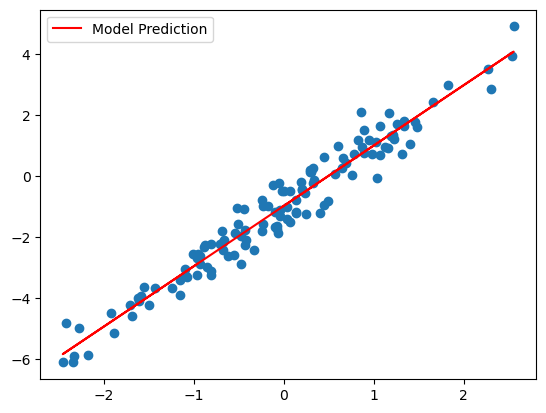

In [96]:
import matplotlib.pyplot as plt

rng = jax.random.key(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend();

In [97]:
init(rng)

Params(weight=Array(0.13790321, dtype=float32), bias=Array(1.3694694, dtype=float32))